# Hand-crafted features for GTZAN

> The goal of this notebook is to create several audio features descriptors for the GTZAN dataset, as proposed for many year as input for machine learning algorithms. We are going to use timbral texture based features and tempo based features for this. The main goal is to produce this features, classify and then compare with our proposed deep learning approach, using CNNs on the raw audio.

> This script is from https://github.com/Hguimaraes/gtzan.keras adapted to my case of 2 specific sub-genres

In [36]:
import os
import librosa
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import kurtosis
from scipy.stats import skew

In [37]:
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel

import lightgbm as lgbm
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [38]:
# Set the seed
np.random.seed(42)

In [39]:
gtzan_dir = '../Data/songs/small_test_set/'

In [40]:
# Parameters
#song_samples = 22050*30
genres = {'black': 0, 'death': 1}

In [41]:
def get_features(y, sr, n_fft = 1024, hop_length = 512):
    # Features to concatenate in the final dictionary
    features = {'centroid': None, 'roloff': None, 'flux': None, 'rmse': None,
                'zcr': None, 'contrast': None, 'bandwidth': None, 'flatness': None}
    
    # Count silence
    if 0 < len(y):
        y_sound, _ = librosa.effects.trim(y, frame_length=n_fft, hop_length=hop_length)
    features['sample_silence'] = len(y) - len(y_sound)

    # Using librosa to calculate the features
    features['centroid'] = librosa.feature.spectral_centroid(y, sr=sr, n_fft=n_fft, hop_length=hop_length).ravel()
    features['roloff'] = librosa.feature.spectral_rolloff(y, sr=sr, n_fft=n_fft, hop_length=hop_length).ravel()
    features['zcr'] = librosa.feature.zero_crossing_rate(y, frame_length=n_fft, hop_length=hop_length).ravel()
    features['rmse'] = librosa.feature.rms(y, frame_length=n_fft, hop_length=hop_length).ravel()
    features['flux'] = librosa.onset.onset_strength(y=y, sr=sr).ravel()
    features['contrast'] = librosa.feature.spectral_contrast(y, sr=sr).ravel()
    features['bandwidth'] = librosa.feature.spectral_bandwidth(y, sr=sr, n_fft=n_fft, hop_length=hop_length).ravel()
    features['flatness'] = librosa.feature.spectral_flatness(y, n_fft=n_fft, hop_length=hop_length).ravel()
    
    # MFCC treatment
    mfcc = librosa.feature.mfcc(y, n_fft = n_fft, hop_length = hop_length, n_mfcc=13)
    for idx, v_mfcc in enumerate(mfcc):
        features['mfcc_{}'.format(idx)] = v_mfcc.ravel()
        
    # Get statistics from the vectors
    def get_moments(descriptors):
        result = {}
        for k, v in descriptors.items():
            result['{}_max'.format(k)] = np.max(v)
            result['{}_min'.format(k)] = np.min(v)
            result['{}_mean'.format(k)] = np.mean(v)
            result['{}_std'.format(k)] = np.std(v)
            result['{}_kurtosis'.format(k)] = kurtosis(v)
            result['{}_skew'.format(k)] = skew(v)
        return result
    
    dict_agg_features = get_moments(features)
    dict_agg_features['tempo'] = librosa.beat.tempo(y, sr=sr)[0]
    
    return dict_agg_features

In [42]:
def read_process_songs(src_dir, debug = True):    
    # Empty array of dicts with the processed features from all files
    arr_features = []

    # Read files from the folders
    for x,_ in genres.items():
        folder = src_dir + x
        
        for root, subdirs, files in os.walk(folder):
            for file in files:
                # Read the audio file
                file_name = folder + "/" + file
                signal, sr = librosa.load(file_name)
                
                # Debug process
                if debug:
                    print("Reading file: {}".format(file_name))
                
                # Append the result to the data structure
                features = get_features(signal, sr)
                features['genre'] = genres[x]
                arr_features.append(features)
    return arr_features

In [43]:
%%time

# Get list of dicts with features and convert to dataframe
features = read_process_songs(gtzan_dir, debug=True)

C:\Users\user\anaconda3\envs\ml38b\lib\site-packages\librosa\core\audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Reading file: ../Data/songs/small_test_set/black/(2)_[Gorgoroth]_A_World_To_Win.ape
Reading file: ../Data/songs/small_test_set/black/(6)_[Gorgoroth]_Ein_Eim_Av_Blod_Og_Helvetesild.ape
Reading file: ../Data/songs/small_test_set/black/01. Unsilent Storms In The North Abyss.flac
Reading file: ../Data/songs/small_test_set/black/02 - Ancient Queen.flac
Reading file: ../Data/songs/small_test_set/black/03 - Night of the Graveless Souls.flac
Reading file: ../Data/songs/small_test_set/black/03 - Night Of The Graveless Souls.mp3
Reading file: ../Data/songs/small_test_set/black/03. Descent Into Eminent Silence.flac
Reading file: ../Data/songs/small_test_set/black/03. Enslaved - Urtical Gods.mp3
Reading file: ../Data/songs/small_test_set/black/04 - The Source Of Icon E.flac
Reading file: ../Data/songs/small_test_set/black/04. Throned By Blackstorms.flac
Reading file: ../Data/songs/small_test_set/black/05. Battlefields.flac
Reading file: ../Data/songs/small_test_set/black/05. Cold Winds of Funeral 

In [44]:
df_features = pd.DataFrame(features)

In [45]:
df_features.shape

(40, 134)

In [46]:
df_features.head()

,centroid_max,centroid_min,centroid_mean,centroid_std,centroid_kurtosis,centroid_skew,roloff_max,roloff_min,roloff_mean,roloff_std,...,mfcc_11_kurtosis,mfcc_11_skew,mfcc_12_max,mfcc_12_min,mfcc_12_mean,mfcc_12_std,mfcc_12_kurtosis,mfcc_12_skew,tempo,genre
0,3869.546804,0.000000,294.828904,825.091792,4.839536,2.562195,7967.285156,0.000000,636.370725,1792.025778,...,16.046562,3.526968,24.730848,-20.040756,0.243008,2.595644,20.454327,2.119749,135.999178,0
1,4534.471484,0.000000,1380.944624,1367.484954,-1.710426,0.096348,8441.015625,0.000000,2756.848071,2710.539600,...,0.375951,1.043961,19.768749,-41.414047,-1.021563,4.933767,4.598924,-1.104690,129.199219,0
2,4295.498784,513.736452,3005.198413,327.010280,2.697415,-0.588897,7816.552734,43.066406,5657.765589,555.879769,...,0.430768,0.115611,17.913080,-35.499874,-7.820831,6.499641,0.153981,0.228145,135.999178,0
3,4215.694354,0.000000,1599.525939,294.882949,8.466247,0.500570,8699.414062,0.000000,3706.825516,576.143101,...,0.155326,-0.061355,22.193771,-21.693535,0.128726,5.681358,0.114515,0.080191,123.046875,0
4,4021.597939,284.709447,2907.742452,398.497750,2.077889,-0.779413,8204.150391,43.066406,6221.766752,665.859390,...,-0.084799,0.157413,14.005433,-30.771206,-9.959908,6.297565,0.327041,0.323007,112.347147,0


In [12]:
df_features.to_csv('../data/full_test_set_features.csv', index=False)

In [47]:
X = df_features.drop(['genre'], axis=1).values
y = df_features['genre'].values

## Visualization

> Linear (and nonlinear) dimensionality reduction of the GTZAN features for visualization purposes

In [48]:
# Standartize the dataset
scale = StandardScaler()
x_scaled = scale.fit_transform(X)

In [49]:
# Use PCA only for visualization
pca = PCA(n_components=35, whiten=True)
x_pca = pca.fit_transform(x_scaled)
print("cumulative explained variance ratio = {:.4f}".format(np.sum(pca.explained_variance_ratio_)))

cumulative explained variance ratio = 0.9966


In [50]:
# Use LDA only for visualization
lda = LDA()
x_lda = lda.fit_transform(x_scaled, y)

In [51]:
# Using tsne
tsne = TSNE(n_components=2, verbose=1, learning_rate=250)
x_tsne = tsne.fit_transform(x_scaled)

C:\Users\user\anaconda3\envs\ml38b\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


[t-SNE] Computing 39 nearest neighbors...
[t-SNE] Indexed 40 samples in 0.032s...
[t-SNE] Computed neighbors for 40 samples in 0.147s...
[t-SNE] Computed conditional probabilities for sample 40 / 40
[t-SNE] Mean sigma: 9.153642
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.195686
[t-SNE] KL divergence after 1000 iterations: 0.412961


(40, 35)
(40, 1)


IndexError: index 1 is out of bounds for axis 1 with size 1

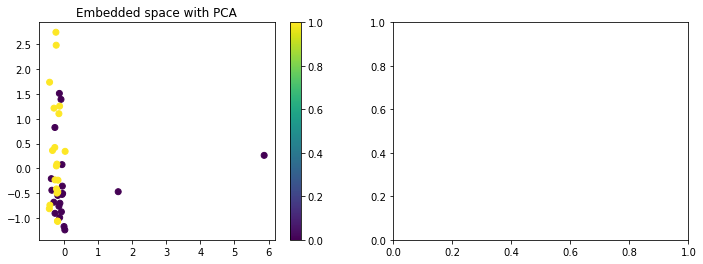

In [52]:
plt.figure(figsize=(18, 4))
plt.subplot(131)
print(x_pca.shape)
plt.scatter(x_pca[:,0], x_pca[:,1], c=y)
plt.colorbar()
plt.title("Embedded space with PCA")

plt.subplot(132)
print(x_lda.shape)
plt.scatter(x_lda[:,0], x_lda[:,1], c=y)
plt.colorbar()
plt.title("Embedded space with LDA")

plt.subplot(133)
plt.scatter(x_tsne[:,0], x_tsne[:,1], c=y)
plt.colorbar()
plt.title("Embedded space with TSNE")
plt.show()

<AxesSubplot:>

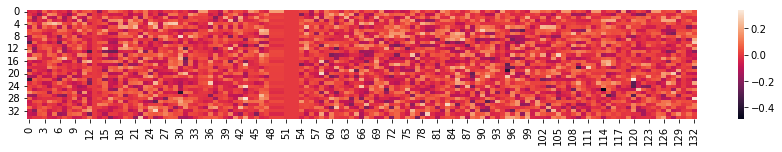

In [53]:
# idea from https://github.com/rodriguezda/PCA/blob/master/pca%20pipeline.ipynb
import seaborn as sns
df = pd.DataFrame(X)
df_component = pd.DataFrame(pca.components_, columns = df.columns)
plt.figure(figsize=(15,2))
sns.heatmap(df_component)

0      48
1      62
2      63
3      40
4      29
5      55
6      90
7     108
8      30
9      86
10    132
11     19
12     40
13     22
14    105
15      7
16     58
17     43
18    111
19     64
20     58
21     95
22    120
23     36
24     43
25    121
26    128
27     46
28    132
29     93
30     83
31     61
32     25
33     79
34     22
dtype: int64


<AxesSubplot:>

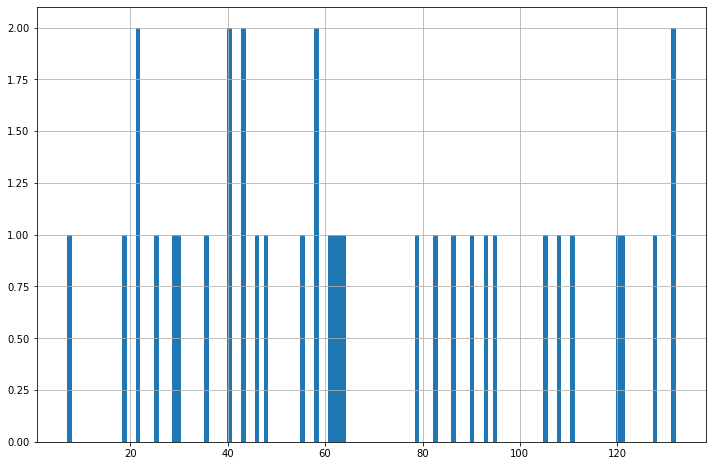

In [54]:
max_vals = df_component.idxmax(1)
print(max_vals)
max_vals.hist(bins=133, figsize=(12,8))

## Classical Machine Learning

In [55]:
# Helper to plot confusion matrix -- from Scikit-learn website
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

### Logistic Regression

In [57]:
params = {
    "cls__penalty": ["l1", "l2"], # penalty norms
    "cls__C": [0.5, 1, 2, 5], # regularisation - smaller is stronger
    "cls__max_iter": [500] # maximum number of iterations
}

pipe_lr = Pipeline([
    ('scale', StandardScaler()),
    ('var_tresh', VarianceThreshold(threshold=(.8 * (1 - .8)))),
    ('feature_selection', SelectFromModel(lgbm.LGBMClassifier())),
    ('cls', LogisticRegression())
])

grid_lr = GridSearchCV(pipe_lr, params, scoring='accuracy', n_jobs=6, cv=5)
grid_lr.fit(X_train, y_train)

C:\Users\user\anaconda3\envs\ml38b\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
20 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\envs\ml38b\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\envs\ml38b\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\user\anaconda3\envs\ml38b\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('var_tresh',
                                        VarianceThreshold(threshold=0.15999999999999998)),
                                       ('feature_selection',
                                        SelectFromModel(estimator=LGBMClassifier())),
                                       ('cls', LogisticRegression())]),
             n_jobs=6,
             param_grid={'cls__C': [0.5, 1, 2, 5], 'cls__max_iter': [500],
                         'cls__penalty': ['l1', 'l2']},
             scoring='accuracy')

In [58]:
preds = grid_lr.predict(X_test)
print("best score on validation set (accuracy) = {:.4f}".format(grid_lr.best_score_))
print("best score on test set (accuracy) = {:.4f}".format(accuracy_score(y_test, preds)))

best score on validation set (accuracy) = 0.8000
best score on test set (accuracy) = 1.0000


### ElasticNet

In [26]:
params = {
    "cls__loss": ['log'],
    "cls__penalty": ["elasticnet"],
    "cls__l1_ratio": [0.15, 0.25, 0.5, 0.75],
}

pipe_en = Pipeline([
    ('scale', StandardScaler()),
    ('var_tresh', VarianceThreshold(threshold=(.8 * (1 - .8)))),
    ('feature_selection', SelectFromModel(lgbm.LGBMClassifier())),
    ('cls', SGDClassifier())
])

grid_en = GridSearchCV(pipe_en, params, scoring='accuracy', n_jobs=6, cv=5)
grid_en.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('var_tresh',
                                        VarianceThreshold(threshold=0.15999999999999998)),
                                       ('feature_selection',
                                        SelectFromModel(estimator=LGBMClassifier())),
                                       ('cls', SGDClassifier())]),
             n_jobs=6,
             param_grid={'cls__l1_ratio': [0.15, 0.25, 0.5, 0.75],
                         'cls__loss': ['log'], 'cls__penalty': ['elasticnet']},
             scoring='accuracy')

In [27]:
preds = grid_en.predict(X_test)
print("best score on validation set (accuracy) = {:.4f}".format(grid_en.best_score_))
print("best score on test set (accuracy) = {:.4f}".format(accuracy_score(y_test, preds)))

best score on validation set (accuracy) = 0.8333
best score on test set (accuracy) = 0.9000


### Decision Tree

In [28]:
params = {
    "cls__criterion": ["gini", "entropy"],
    "cls__splitter": ["best", "random"],
}

pipe_cart = Pipeline([
    ('var_tresh', VarianceThreshold(threshold=(.8 * (1 - .8)))),
    ('feature_selection', SelectFromModel(lgbm.LGBMClassifier())),
    ('cls', DecisionTreeClassifier())
])

grid_cart = GridSearchCV(pipe_cart, params, scoring='accuracy', n_jobs=6, cv=5)
grid_cart.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('var_tresh',
                                        VarianceThreshold(threshold=0.15999999999999998)),
                                       ('feature_selection',
                                        SelectFromModel(estimator=LGBMClassifier())),
                                       ('cls', DecisionTreeClassifier())]),
             n_jobs=6,
             param_grid={'cls__criterion': ['gini', 'entropy'],
                         'cls__splitter': ['best', 'random']},
             scoring='accuracy')

In [29]:
preds = grid_cart.predict(X_test)
print("best score on validation set (accuracy) = {:.4f}".format(grid_cart.best_score_))
print("best score on test set (accuracy) = {:.4f}".format(accuracy_score(y_test, preds)))

best score on validation set (accuracy) = 0.8333
best score on test set (accuracy) = 0.9000


### Random Forest

In [30]:
params = {
    "cls__n_estimators": [100, 250, 500, 1000],
    "cls__criterion": ["gini", "entropy"],
    "cls__max_depth": [5, 7, None]
}

pipe_rf = Pipeline([
    ('var_tresh', VarianceThreshold(threshold=(.8 * (1 - .8)))),
    ('feature_selection', SelectFromModel(lgbm.LGBMClassifier())),
    ('cls', RandomForestClassifier())
])

grid_rf = GridSearchCV(pipe_rf, params, scoring='accuracy', n_jobs=6, cv=5)
grid_rf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('var_tresh',
                                        VarianceThreshold(threshold=0.15999999999999998)),
                                       ('feature_selection',
                                        SelectFromModel(estimator=LGBMClassifier())),
                                       ('cls', RandomForestClassifier())]),
             n_jobs=6,
             param_grid={'cls__criterion': ['gini', 'entropy'],
                         'cls__max_depth': [5, 7, None],
                         'cls__n_estimators': [100, 250, 500, 1000]},
             scoring='accuracy')

In [31]:
preds = grid_rf.predict(X_test)
print("best score on validation set (accuracy) = {:.4f}".format(grid_rf.best_score_))
print("best score on test set (accuracy) = {:.4f}".format(accuracy_score(y_test, preds)))

best score on validation set (accuracy) = 0.9333
best score on test set (accuracy) = 0.9000


### SVM

In [32]:
params = {
    "cls__C": [0.5, 1, 2, 5],
    "cls__kernel": ['rbf', 'linear', 'sigmoid'],
}

pipe_svm = Pipeline([
    ('scale', StandardScaler()),
    ('var_tresh', VarianceThreshold(threshold=(.8 * (1 - .8)))),
    ('feature_selection', SelectFromModel(lgbm.LGBMClassifier())),
    ('cls', SVC())
])

grid_svm = GridSearchCV(pipe_svm, params, scoring='accuracy', n_jobs=6, cv=5)
grid_svm.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('var_tresh',
                                        VarianceThreshold(threshold=0.15999999999999998)),
                                       ('feature_selection',
                                        SelectFromModel(estimator=LGBMClassifier())),
                                       ('cls', SVC())]),
             n_jobs=6,
             param_grid={'cls__C': [0.5, 1, 2, 5],
                         'cls__kernel': ['rbf', 'linear', 'sigmoid']},
             scoring='accuracy')

In [33]:
preds = grid_svm.predict(X_test)
print("best score on validation set (accuracy) = {:.4f}".format(grid_svm.best_score_))
print("best score on test set (accuracy) = {:.4f}".format(accuracy_score(y_test, preds)))

best score on validation set (accuracy) = 0.8667
best score on test set (accuracy) = 0.9000


## Results and save the model

In [34]:
cm = confusion_matrix(y_test, preds)
classes = ['black', 'death']

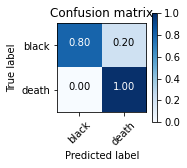

In [35]:
plt.figure(figsize=(2,2))
plot_confusion_matrix(cm, classes, normalize=True)

In [ ]:
import joblib

In [ ]:
joblib.dump(grid_svm, "../Models/pipe_svm_balanced.joblib")

['../Models/pipe_svm_balanced.joblib']